In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [156]:
defaultParameters(df)['P0']

array([[117.64052346,   0.        ],
       [  0.        , 122.40893199]])

---
#### Testing Bivariate

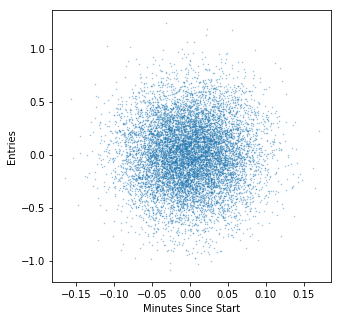

In [231]:
x = []
y = []
Q = [[.002, 0.], [0., .1]]

for i in range(0, 10000):
    val = np.random.multivariate_normal([0, 0], Q)
    x.append(val[0])
    y.append(val[1])
df = pd.DataFrame({'X':x, 'Y':y})
plotSeries(df)

In [197]:
def plotScatter(df, title=""):
    df = df.assign(plotX=df['X']).assign(plotY=df['Y'])

    fig = plt.figure()
    fig.set_size_inches([5, 5])
    ax = fig.add_subplot(111)
    
    ax.set_xlabel("Minutes Since Start")
    ax.set_xlim(xmin=df['plotX'].min()*1.1, xmax=df['plotX'].max()*1.1)

    ax.set_ylabel("Entries")
    ax.set_ylim(ymin=df['plotY'].min()*1.1, ymax=df['plotY'].max()*1.1)

    
    ax.scatter(df['plotX'], df['plotY'], s=.2, alpha=.5)
    ax.set_title(title)

In [207]:
def genData(A, B, time, mu, sigma):
    measureNoise = np.random.normal(mu, sigma, time)
    noiseyY, normalY = [], []
    for i in range(0, time):
        val = A*np.exp(i*B)
        normalY.append(val)
        noiseyY.append(val + measureNoise[i])
    return noiseyY, normalY

def defaultParameters(df):
    random_state = np.random.RandomState(0)
    F = np.eye(2) #Transition Matrix (Identity Matrix)

    Z = list(df['Y']) #Observation matrix
    X0 = [[4.], [.0023]] #Inital parameters guess (?) <<<< NEED VALUES
    P0 = (np.eye(2))*1000 #Covariance Matrix (The confidence in our prediction)
    R = 100
    Q = [[0,0.],[0.,0]]
    w = np.random.multivariate_normal([0., 0.], Q)
    return {'random_state':random_state, 'F':F, 'Z':Z, 'X0':X0, 'P0':P0, 'R':R, 'Q':Q, 'w':w}

def kalmanPredictNextVal(tCurr, xCurr,parameters, extended=False):
    if(extended):
        part1 = np.exp(xCurr[1][0]*tCurr)
        Hk = [part1, part1*(xCurr[0][0]*tCurr)]
        Zk = xCurr[0][0]*np.exp(xCurr[1][0]*tCurr)
        return Hk,  Zk
    else:
        Hk = [1., tCurr]
        Zk = np.dot(Hk, xCurr) + np.random.normal(loc=0., scale=parameters['R']) #<----- Consider putting Vk instead of R
        return Hk,  Zk
    
def kalmanFilter(series, parameters, extended=False):
    Xs = []
    
    Pk = parameters['P0'] 
    Xk = parameters['X0'] 
    for n in range(0, len(series)):
        actual = np.array(series.iloc[n]['Y']) #Current actual
        time = np.array(series.iloc[n]['X']) #Current time
        Pk = Pk + parameters["Q"]

        Hk, Zk = kalmanPredictNextVal(time, Xk, parameters, extended=extended) 
        Yk = actual - Zk # residuals
        transposedH = [[Hk[0]],[Hk[1]]]
        Sk = np.dot(np.dot(Hk, Pk), transposedH)[0]+parameters['R']
        Kk = np.dot(Pk, transposedH)*(1/Sk)
        Xnext = Xk + Kk*Yk        
        p_part = (np.eye(2)-np.outer(Kk, Hk))
        Pnext = np.dot(p_part, Pk)
        
        Xs.append([Xk[0][0], Xk[1][0]])
        #Set new vars based on current observation
        Pk = Pnext
        Xk = Xnext
    return Xs

In [219]:
def genBiData(A, B, times, mu, sigma, Q):
    measureNoise = np.random.normal(mu, sigma, len(times))
    measuredY = []
    for i in times:
        noise = np.random.multivariate_normal([0, 0], Q)
        Ax, Bx = A+noise[0], B+noise[1]
        val = Ax*np.exp(Bx*i)
        measuredY.append(val + measureNoise[i])
        A, B = Ax, Bx
    return measuredY

def plotLine(df, title=""):
    df = df.assign(plotX=df['X']).assign(plotY=df['Y'])

    fig = plt.figure()
    fig.set_size_inches([5, 5])
    ax = fig.add_subplot(111)
    
    ax.set_xlabel("Minutes Since Start")
    ax.set_xlim(0., xmax=df['plotX'].max()*1.1)

    ax.set_ylabel("Entries")
    ax.set_ylim(ymin=df['plotY'].min()*1.1, ymax=df['plotY'].max()*1.1)

    
    ax.line(df['plotX'], df['plotY'])
    ax.set_title(title)

In [246]:
A, B = 44.1, 0.00058
mu, sigma = 0, 40.0 # mean and standard deviation
Q = [[1, 0.], [0., 2]]
numSteps = 1000

xs = range(0, numSteps)
ys = genBiData(A, B, xs, mu, sigma, Q)

df = pd.DataFrame({'X':xs, 'Y':ys})


In [248]:
df.tail(10)

,X,Y
990,990,-43.804080
991,991,38.994746
992,992,-42.919963
993,993,8.492490
994,994,0.011166
995,995,19.587798
996,996,10.224062
997,997,29.102927
998,998,31.271438
999,999,3.799139


ValueError: Axis limits cannot be NaN or Inf

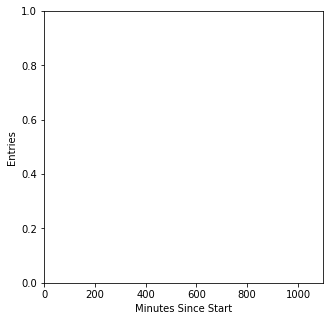

In [221]:
plotLine(df)

In [212]:
A, B = 44.1, 0.0058
mu, sigma = 0, 100.0 # mean and standard deviation

xs = range(0, 1000)
ys = genData(A, B, xs, mu, sigma)

df = pd.DataFrame(data={"X":xs, "Y":ys})

AB = kalmanFilter(df, defaultParameters(df), extended=True)[-1:][0]

plt.scatter(xs, ys, s=.04)

ys, trueYs = genData(AB[0], AB[1], 1000, mu, sigma)

plt.plot(xs, trueYs, alpha=.5, c='red')
AB

ValueError: sequence too large; cannot be greater than 32